# Exploratory Data Analysis 

TASKS: 
- understand the relationships between historical weather observations and the river gauge levels
- explore the missing values
- lagged variables? 
- visualisations of all above



In [10]:
os.chdir('..')

In [26]:


import pandas as pd
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import datetime as dt 
from src.data_collection import fetch_and_save_river_data
from src.transform_data import extract_time_values_from_csv, check_missing_days_in_csv
from src.transform_data import remove_negative_river_levels
import os 
import sys

## Plan of attack 
- Initially, we analyse river gauge and weather data separately
- Further, start with a single csv for river data, perform EDA on this
- Key requirements: missing values visualised, percentages 
- Develop code to create an EDA.py script so these functions are easily accesible later in the project: break down into different classes : IE class River, class Weather 
- Can generalise the river EDA to all 30 stations
- Weather data is simpler, we currently have one Cornwall station from NOAA
- After look at the relationships between water levels and weather data



Chose station 1335 randomly, it's Helston Country Bridge

In [12]:
station_1335 = pd.read_csv('./data/river_data/station_1335_clean.csv')

In [13]:
station_1335

,time,value
0,2014-03-04 04:15:00,0.772
1,2014-03-04 04:30:00,0.771
2,2014-03-04 04:45:00,0.771
3,2014-03-04 05:00:00,0.770
4,2014-03-04 05:15:00,0.771
...,...,...
276563,2024-07-11 21:15:00,0.320
276564,2024-07-11 21:45:00,0.318
276565,2024-07-11 22:30:00,0.319
276566,2024-07-11 22:45:00,0.317


In [14]:
station_1335.isnull().sum() # No nulls, but there are gaps in the days


time     0
value    0
dtype: int64

In [15]:
station_1335['time'] = pd.to_datetime(station_1335['time']) # convert to datetime

In [16]:
station_1335['time'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 276568 entries, 0 to 276567
Series name: time
Non-Null Count   Dtype         
--------------   -----         
276568 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.1 MB


In [17]:
station_1335.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276568 entries, 0 to 276567
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   time    276568 non-null  datetime64[ns]
 1   value   276568 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.2 MB


In [18]:
station_1335.describe()

,time,value
count,276568,276568.000000
mean,2019-04-07 11:35:25.104856576,0.482313
min,2014-03-04 04:15:00,-32.768000
25%,2016-08-21 03:22:30,0.277000
50%,2019-02-01 02:15:00,0.415000
75%,2022-01-08 01:11:15,0.616000
max,2024-07-11 23:45:00,2.044000
std,NaN,0.271497


In [13]:
# the min water level is -32? 

station_1335[station_1335['value'] ==station_1335['value'].min() ]

,time,value
191028,2021-03-12 08:15:00,-32.768
191029,2021-03-12 12:15:00,-32.768


<Axes: title={'center': 'Distribution of River Gauge Levels'}, ylabel='Frequency'>

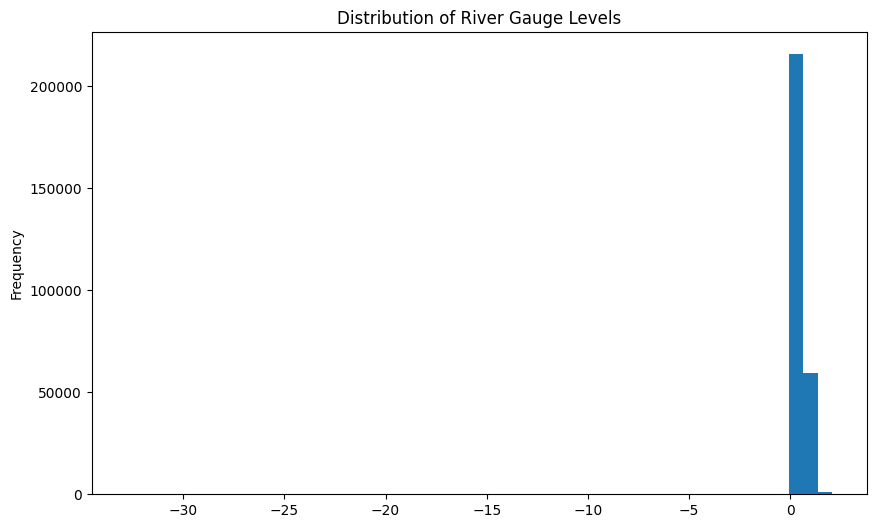

In [14]:
station_1335['value'].plot(kind='hist', bins=50, figsize=(10, 6), title='Distribution of River Gauge Levels')


In [14]:
negative_values = station_1335[station_1335['value'] < 0]
print(f"Number of negative values: {len(negative_values)}")
print(negative_values.head())  # Display the first few negative values


Number of negative values: 2
                      time   value
191028 2021-03-12 08:15:00 -32.768
191029 2021-03-12 12:15:00 -32.768


In [15]:
reasonable_range = station_1335[(station_1335['value'] >= 0) & (station_1335['value'] <= 5)]
unreasonable_values = station_1335[~station_1335.index.isin(reasonable_range.index)]
print(f"Unreasonable values count: {len(unreasonable_values)}")


Unreasonable values count: 2


In [19]:
station_1335['value'] = station_1335['value'].apply(lambda x: np.nan if x < 0 else x)


In [20]:
station_1335.describe()

,time,value
count,276568,276566.000000
mean,2019-04-07 11:35:25.104856576,0.482554
min,2014-03-04 04:15:00,0.144000
25%,2016-08-21 03:22:30,0.277000
50%,2019-02-01 02:15:00,0.415000
75%,2022-01-08 01:11:15,0.616000
max,2024-07-11 23:45:00,2.044000
std,NaN,0.256352


<Axes: title={'center': 'River Levels Over Time (Station 1335)'}, xlabel='time'>

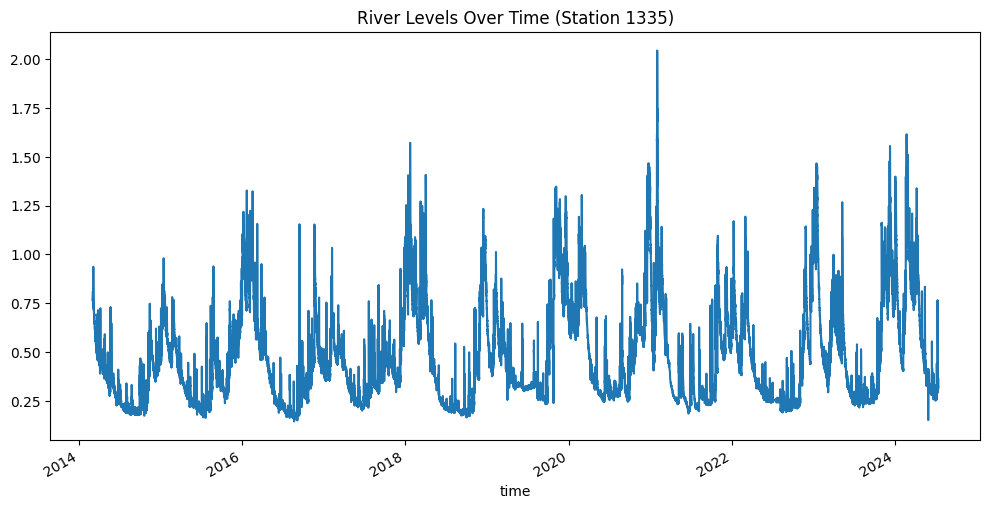

In [21]:
station_1335.set_index('time')['value'].plot(figsize=(12, 6), title='River Levels Over Time (Station 1335)')


In [25]:
# Filter for rows in the year 2021
station_1335_2021 = station_1335[station_1335['time'].dt.year == 2021]

# Get the row with the maximum value for 2021
max_value_row_2021 = station_1335_2021.loc[station_1335_2021['value'].idxmax(), ['time', 'value']]
max_value_row_2021


time     2021-01-31 18:00:00
value                  2.044
Name: 188901, dtype: object

In [26]:
station_1335_2024 = station_1335[station_1335['time'].dt.year == 2024]
max_value_row_2024 = station_1335_2024.loc[station_1335_2024['value'].idxmax(), ['time', 'value']]
max_value_row_2024

time     2024-02-21 11:45:00
value                  1.615
Name: 265875, dtype: object

Seasonality: There are repeating patterns visible, with peaks and troughs occurring fairly regularly. This indicates some level of seasonality, likely related to rainfall or weather conditions.
Anomalies: There are a few periods with very high spikes in river levels, especially in 2019 and early 2020, which could be indicative of extreme weather events or floods.
Trend: It appears that the river levels have consistent fluctuations, without any obvious long-term upward or downward trend, though there might be slight variations over the years.
Range: The river levels seem to range mostly between 0.25 and 1.75 meters, which might indicate typical ranges for the station.

In [ ]:
# What about Boscastle flood in 2004? 

In [3]:
from datetime import datetime as dt
from data_collection import fetch_and_save_river_data


fetch_and_save_river_data(
    station_ids=['1335'], 
    start_date='2003-01-01T00:00:00Z', 
    end_date=dt.today().isoformat(),  # Get the current date in ISO format
    destination='/Users/antonfreidin/water_project/boscastle '
)


Data for station 1335 saved successfully in /Users/antonfreidin/water_project/boscastle /station_1335.csv.


In [5]:
path = '/Users/antonfreidin/water_project/boscastle /station_1335.csv'
bc_1335 = pd.read_csv(path)

In [8]:
extract_time_values_from_csv(path) #earliest date 2014 unfortunately 

,value
time,
2014-03-04 04:15:00,0.772
2014-03-04 04:30:00,0.771
2014-03-04 04:45:00,0.771
2014-03-04 05:00:00,0.770
2014-03-04 05:15:00,0.771
...,...
2024-10-24 09:00:00,0.784
2024-10-24 09:15:00,0.783
2024-10-24 09:30:00,0.784


In [15]:
# Calculate the difference between consecutive timestamps
station_1335['time_diff'] = station_1335['time'].diff()

# Check the distribution of time differences to find the most common interval
station_1335['time_diff'].value_counts().head()


time_diff
0 days 00:15:00    230483
0 days 00:30:00     32561
0 days 00:45:00      8073
0 days 01:00:00      2431
0 days 01:15:00      1118
Name: count, dtype: int64

In [17]:
# Assuming daily data, check for gaps greater than 1 day
missing_days = station_1335[station_1335['time_diff'] > pd.Timedelta(days=1)]

# Display the missing periods
missing_days[['time', 'time_diff']]

missing_days.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38 entries, 1074 to 267342
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype          
---  ------     --------------  -----          
 0   time       38 non-null     datetime64[ns] 
 1   value      38 non-null     float64        
 2   time_diff  38 non-null     timedelta64[ns]
dtypes: datetime64[ns](1), float64(1), timedelta64[ns](1)
memory usage: 1.2 KB


In [23]:
# only 38?

check_missing_days_in_csv('get_river_data/data/station_1335_clean.csv')

(DatetimeIndex(['2014-03-04', '2014-03-06', '2014-03-09', '2014-03-17',
                '2014-03-18', '2014-03-19', '2014-03-25', '2014-03-26',
                '2014-04-01', '2014-04-02',
                ...
                '2024-06-16', '2024-06-24', '2024-06-28', '2024-07-01',
                '2024-07-03', '2024-07-05', '2024-07-06', '2024-07-07',
                '2024-07-08', '2024-07-10'],
               dtype='datetime64[ns]', name='time', length=986, freq=None),
 26.063970393867304)

In [23]:
import pandas as pd

def check_missing_timestamps(file_path):
    """Check for missing timestamps in quarter-hourly river gauge data."""
    # Read the CSV file
    river_data = pd.read_csv(file_path)
    
    # Convert the 'time' column to datetime (adjust the column name if needed)
    river_data['time'] = pd.to_datetime(river_data['time'])
    
    # Sort the data by time just in case
    river_data = river_data.sort_values(by='time')
    
    # Calculate the difference between consecutive timestamps
    river_data['time_diff'] = river_data['time'].diff()
    
    # Expected time difference is 15 minutes (900 seconds)
    missing_timestamps = river_data[river_data['time_diff'] > pd.Timedelta(minutes=15)]
    
    # Calculate the total number of gaps
    total_gaps = len(missing_timestamps)
    
    # Calculate the percentage of rows with missing timestamps
    total_rows = len(river_data)
    missing_percentage = (total_gaps / total_rows) * 100 if total_rows > 0 else 0
    
    return missing_timestamps, missing_percentage

# Example usage
file_path = '/Users/antonfreidin/water_project/data/river_data/station_1335_clean.csv'
missing_timestamps, missing_percentage = check_missing_timestamps(file_path)

print("Missing Timestamps:\n", missing_timestamps[['time', 'time_diff']])
print(f"Percentage of Rows with Missing Timestamps: {missing_percentage:.2f}%")


Missing Timestamps:
                       time       time_diff
38     2014-03-04 14:00:00 0 days 00:30:00
43     2014-03-04 15:30:00 0 days 00:30:00
49     2014-03-04 17:15:00 0 days 00:30:00
50     2014-03-04 17:45:00 0 days 00:30:00
55     2014-03-04 19:15:00 0 days 00:30:00
...                    ...             ...
276561 2024-07-11 20:15:00 0 days 00:30:00
276563 2024-07-11 21:15:00 0 days 00:45:00
276564 2024-07-11 21:45:00 0 days 00:30:00
276565 2024-07-11 22:30:00 0 days 00:45:00
276567 2024-07-11 23:45:00 0 days 01:00:00

[46084 rows x 2 columns]
Percentage of Rows with Missing Timestamps: 16.66%


## Time Series Decomposition

### looks like additive decomposition makes sense, given no appearance of trend. 

In [24]:
station_1335 = pd.read_csv('/Users/antonfreidin/water_project/data/river_data/station_1335_clean.csv', parse_dates=['time'], index_col='time')

In [ ]:
station_1335 = station_1335.cle

In [29]:
station_1335['value'].min()

np.float64(0.144)

In [27]:
station_1335 = remove_negative_river_levels(station_1335)

In [34]:
station_1335.asfreq('15min').isnull().sum()

value    86585
dtype: int64

In [35]:
station_1335 = station_1335.asfreq('15min')


In [36]:
station_1335['value'] = station_1335['value'].interpolate(method='linear') #for the sake of decomopsition

In [37]:
station_1335.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 363151 entries, 2014-03-04 04:15:00 to 2024-07-11 23:45:00
Freq: 15min
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   value   363151 non-null  float64
dtypes: float64(1)
memory usage: 5.5 MB


In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [39]:
station_1335.isnull().sum()

value    0
dtype: int64

In [40]:
daily_decomposed = seasonal_decompose(station_1335['value'], model='additive', period=96) # daily seasonality? 

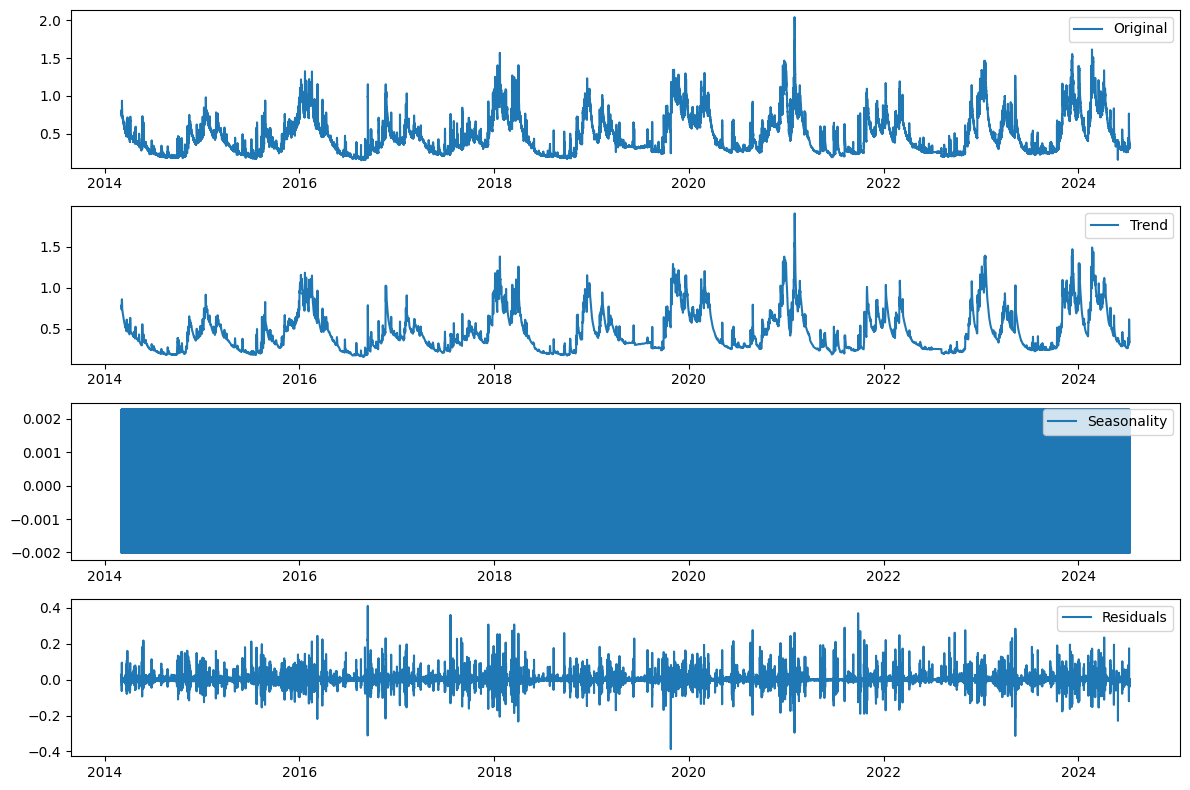

In [41]:
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(station_1335['value'], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(daily_decomposed.trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(daily_decomposed.seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(daily_decomposed.resid, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

In [42]:
yearly_decomposed = seasonal_decompose(station_1335['value'], model='additive', period=96 * 365) # yearly seasonality? 

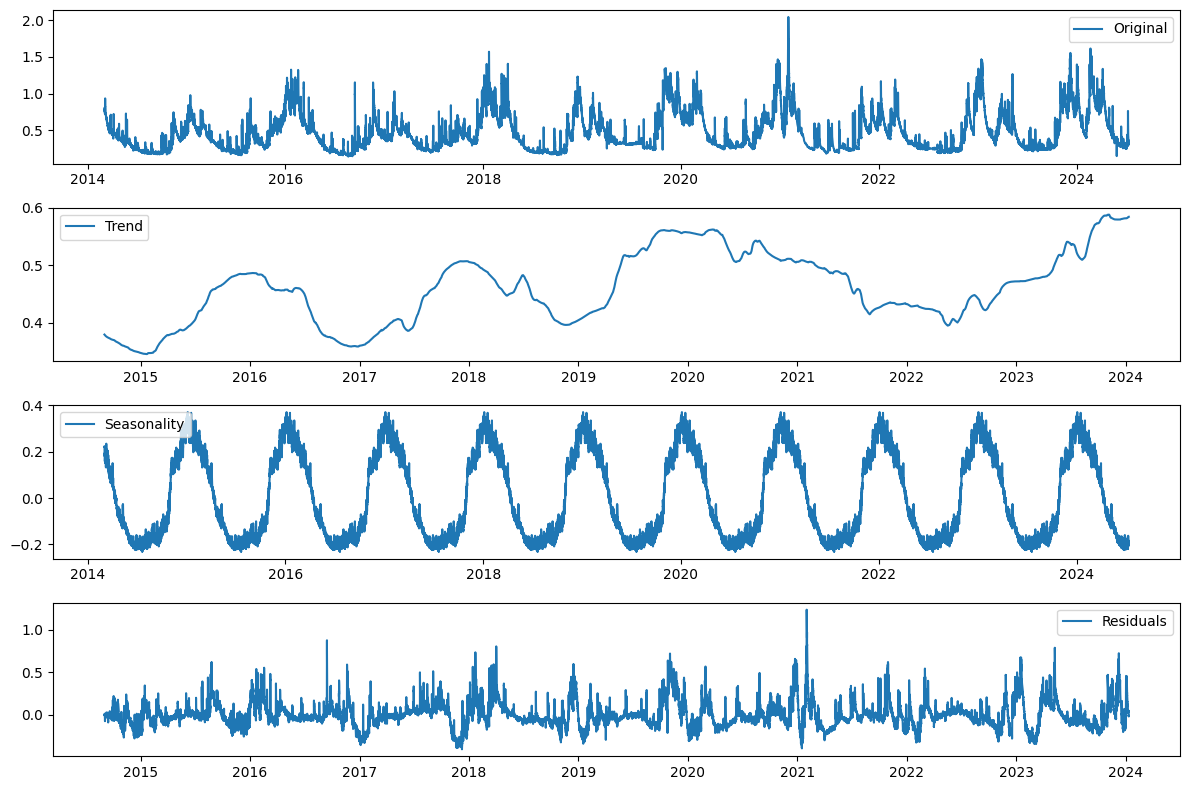

In [43]:
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(station_1335['value'], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(yearly_decomposed.trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(yearly_decomposed.seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(yearly_decomposed.resid, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

In [44]:
yearly_mult_decomposed = seasonal_decompose(station_1335['value'], model='multiplicative', period=96 * 365)

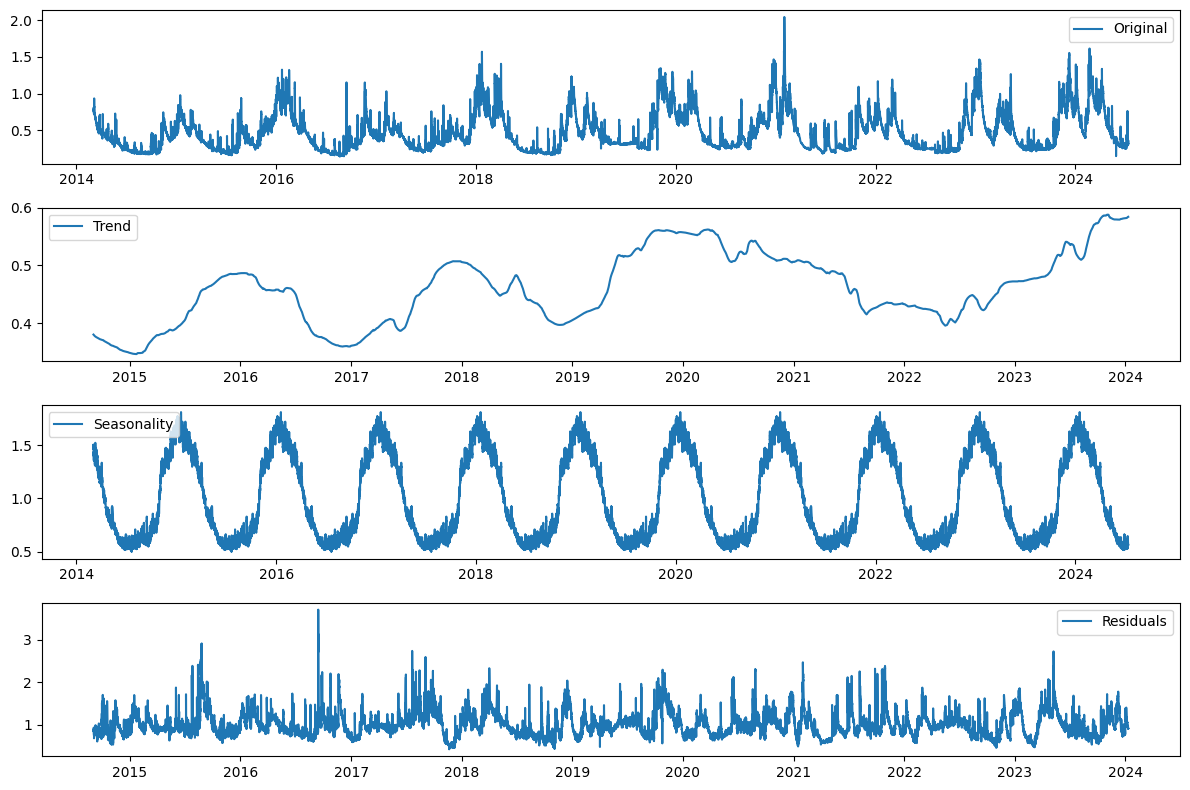

In [45]:
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(station_1335['value'], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(yearly_mult_decomposed.trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(yearly_mult_decomposed.seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(yearly_mult_decomposed.resid, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()